In [100]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 
from sklearn.compose import make_column_selector


# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag # for bagging
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

## Explore data

In [199]:
df_19 = pd.read_csv("df_19.csv")

In [200]:
df_19.describe()

,total_mwh,total_cust,no,saidi_nomed,pv_pct,wind_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
count,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,2.877815e+06,1.325098e+05,12300.241199,138.778774,0.063395,0.002529,0.067048,0.368537,0.018130,4.560795
std,8.153767e+06,3.853289e+05,8559.434421,141.224948,0.496224,0.029555,0.512212,1.061427,0.179930,13.820391
min,2.829000e+03,4.100000e+01,97.000000,0.655000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.374375e+05,1.095350e+04,5896.000000,55.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.314040e+05,2.415200e+04,12268.000000,99.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.484748e+06,6.527150e+04,16715.000000,170.259500,0.007916,0.000000,0.008568,0.237313,0.000000,0.035619
max,1.119557e+08,5.061483e+06,60839.000000,1239.300000,10.630452,0.758238,10.630452,10.727103,3.509534,100.000000


In [201]:
y = df_19['saidi_nomed']
X = df_19[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]

In [202]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [203]:
print(train_X.shape[0]/df_19.shape[0])
print(test_X.shape[0]/df_19.shape[0])

0.7496740547588006
0.2503259452411995


In [205]:
df_19.skew()

total_mwh            6.847969
total_cust           6.647667
no                   2.021330
saidi_nomed          3.002114
pv_pct              16.955088
wind_pct            22.522086
nm_pct              16.647358
ee_pct               5.537040
dem_res_pct         14.958544
dem_res_cust_pct     4.351490
dtype: float64

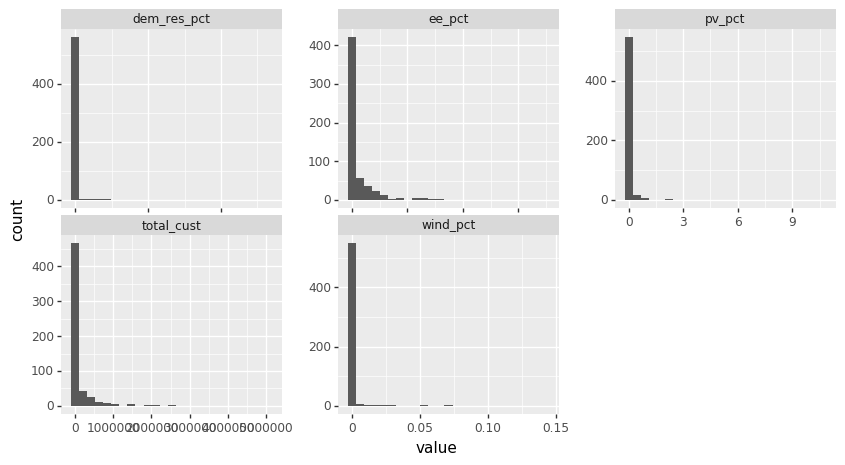

<ggplot: (8765492355937)>

In [204]:
# Plot the continuous variables 
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

In [54]:
df_19_v2 = train_X.copy()

In [55]:
df_19_v2['total_cust'] = np.log(df_19_v2['total_cust'])
#df_19_v2['pv_pct'] = np.log(df_19_v2['pv_pct'] + 1)
df_19_v2['wind_pct'] = np.log(df_19_v2['wind_pct'] + 1)
df_19_v2['ee_pct'] = np.log(df_19_v2['ee_pct'] + 1)
df_19_v2['dem_res_pct'] = np.log(df_19_v2['dem_res_pct'] + 1)

median_pv_pct = df_19_v2.loc[df_19_v2['pv_pct'] > 0,'pv_pct'].median()
df_19_v2['pv_pct'] =  np.where(df_19_v2['pv_pct']==0,0,np.where(df_19_v2['pv_pct'] <= median_pv_pct,1,2))

In [56]:
df_19_v2.describe()

,total_cust,pv_pct,wind_pct,ee_pct,dem_res_pct
count,575.000000,575.000000,575.000000,575.000000,575.000000
mean,10.311081,0.518261,0.001459,0.204278,0.010696
std,1.645047,0.771394,0.009319,0.400916,0.079764
min,3.713572,0.000000,0.000000,0.000000,0.000000
25%,9.268609,0.000000,0.000000,0.000000,0.000000
50%,10.101600,0.000000,0.000000,0.000000,0.000000
75%,11.086567,1.000000,0.000000,0.241087,0.000000
max,15.437170,2.000000,0.132745,2.437136,1.294458


In [195]:
df_19_log = df_19.copy()

# Version 1 just log everything
df_19_log['total_cust'] = np.log(df_19['total_cust'])
df_19_log['pv_pct'] = np.log(df_19['pv_pct'] + 1)
df_19_log['wind_pct'] = np.log(df_19['wind_pct'] + 1)
df_19_log['ee_pct'] = np.log(df_19['ee_pct'] + 1)
df_19_log['dem_res_pct'] = np.log(df_19['dem_res_pct'] + 1)

In [196]:
df_19_log.skew()

total_mwh            6.847969
total_cust          -0.289370
no                   2.021330
saidi_nomed          3.002114
pv_pct               6.696246
wind_pct            18.572395
nm_pct              16.647358
ee_pct               1.969210
dem_res_pct         10.148395
dem_res_cust_pct     4.351490
dtype: float64

In [197]:
y = df_19_log['saidi_nomed']
X = df_19_log[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
train_X_log, test_X_log, train_y_log, test_y_log = train_test_split(X,y,test_size=.25,random_state=1997)

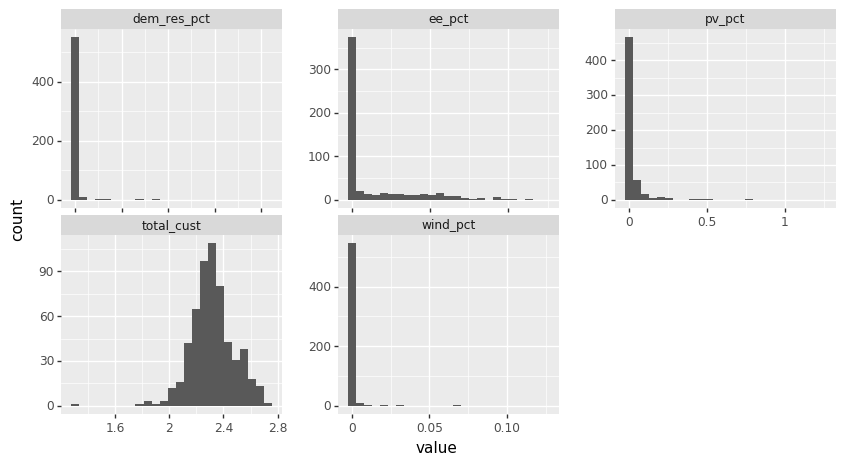

<ggplot: (8765491859777)>

In [198]:
(
    ggplot(train_X_log.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

In [189]:
# Version 2 use the medians too

df_19_med = df_19.copy() 

df_19_med['total_cust'] = np.log(df_19_med['total_cust'])

median_pv_pct = df_19.loc[df_19_med['pv_pct'] > 0,'pv_pct'].median()
df_19_med['pv_pct'] =  np.where(df_19_med['pv_pct']==0,0,np.where(df_19_med['pv_pct'] <= median_pv_pct,1,2))

median_wind_pct = df_19_med.loc[df_19_med['wind_pct'] > 0,'wind_pct'].median()
df_19_med['wind_pct'] =  np.where(df_19_med['wind_pct']==0,0,np.where(df_19_med['wind_pct'] <= median_pv_pct,1,2))

median_ee_pct = df_19_med.loc[df_19_med['ee_pct'] > 0,'ee_pct'].median()
df_19_med['ee_pct'] =  np.where(df_19_med['ee_pct']==0,0,np.where(df_19_med['ee_pct'] <= median_pv_pct,1,2))

median_dr_pct = df_19_med.loc[df_19_med['dem_res_pct'] > 0,'dem_res_pct'].median()
df_19_med['dem_res_pct'] =  np.where(df_19_med['dem_res_pct']==0,0,np.where(df_19_med['dem_res_pct'] <= median_pv_pct,1,2))

In [190]:
df_19_med.skew()

total_mwh            6.847969
total_cust          -0.289370
no                   2.021330
saidi_nomed          3.002114
pv_pct               1.087122
wind_pct             2.617271
nm_pct              16.647358
ee_pct               0.555169
dem_res_pct          2.611474
dem_res_cust_pct     4.351490
dtype: float64

In [192]:
y = df_19_med['saidi_nomed']
X = df_19_med[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
train_X_med, test_X_med, train_y_med, test_y_med = train_test_split(X,y,test_size=.25,random_state=1997)

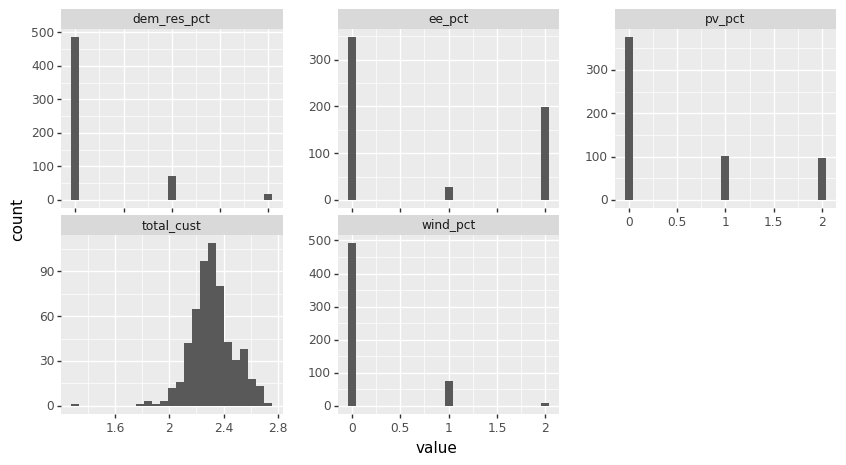

<ggplot: (8765489696977)>

In [194]:
(
    ggplot(train_X_med.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

# Compare skews

In [228]:
pd.DataFrame({
'OG': train_X.skew(),
'log':train_X_log.skew(),
'med':train_X_med.skew(),
'sqrt':train_X_sqrt.skew(),
'box-cox':train_X_box.skew()})

,OG,log,med,sqrt,box-cox
total_cust,6.277885,-0.342958,-0.342958,6.277885,6.277885
pv_pct,18.323346,6.074081,1.073929,6.293732,1.676661
wind_pct,9.507555,9.052274,2.502709,5.888516,3.691725
ee_pct,5.119857,1.864849,0.537393,2.109876,1.001700
dem_res_pct,14.746790,9.664468,2.510140,8.093086,3.708410


In [214]:
# Version 4 use sqrt transform 
df_19_sqrt = df_19.copy()

df_19_sqrt['pv_pct'] = np.sqrt(df_19_sqrt['pv_pct'])
df_19_sqrt['wind_pct'] = np.sqrt(df_19_sqrt['wind_pct'])
df_19_sqrt['ee_pct'] = np.sqrt(df_19_sqrt['ee_pct'])
df_19_sqrt['dem_res_pct'] = np.sqrt(df_19_sqrt['dem_res_pct'])

In [215]:
y = df_19_sqrt['saidi_nomed']
X = df_19_sqrt[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
train_X_sqrt, test_X_sqrt, train_y_sqrt, test_y_sqrt = train_test_split(X,y,test_size=.25,random_state=1997)

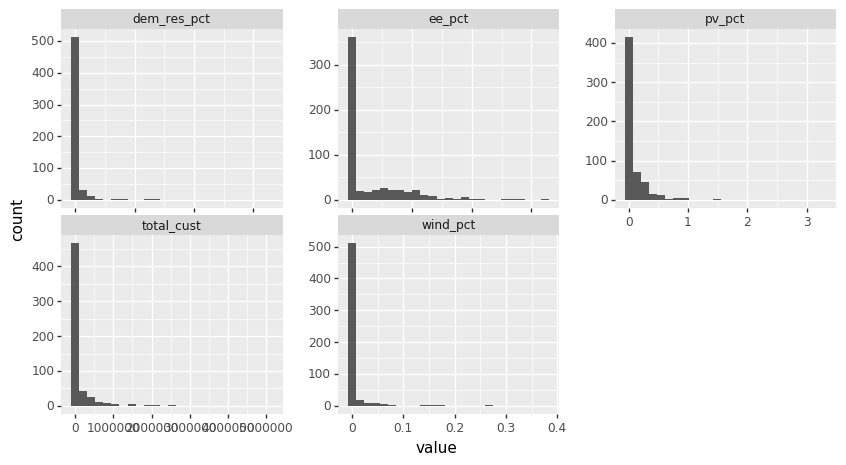

<ggplot: (8765490032401)>

In [217]:
(
    ggplot(train_X_sqrt.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

In [220]:
from scipy import stats

In [225]:
# Version 5 use box-cox
df_19_box = df_19.copy()

df_19_box['pv_pct'] = stats.boxcox(df_19_box['pv_pct'] + 1)[0]
df_19_box['wind_pct'] = stats.boxcox(df_19_box['wind_pct'] + 1)[0]
df_19_box['ee_pct'] = stats.boxcox(df_19_box['ee_pct']+ 1)[0]
df_19_box['dem_res_pct'] = stats.boxcox(df_19_box['dem_res_pct'] + 1)[0]

In [226]:
y = df_19_box['saidi_nomed']
X = df_19_box[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
train_X_box, test_X_box, train_y_box, test_y_box = train_test_split(X,y,test_size=.25,random_state=1997)

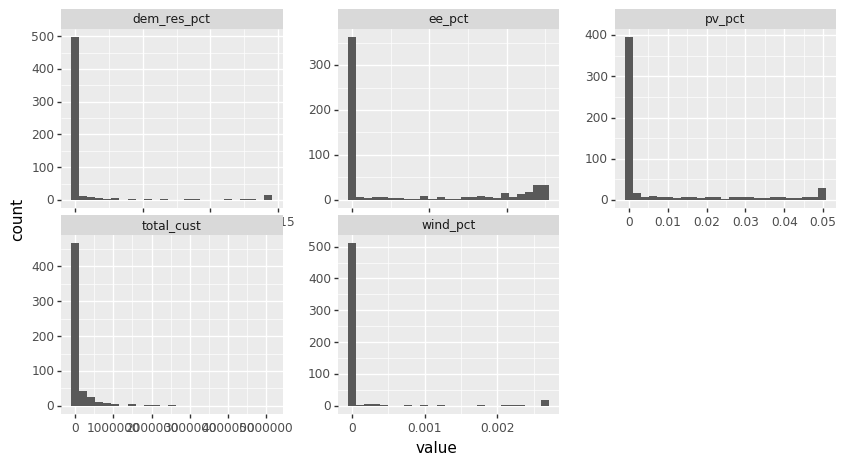

<ggplot: (8765492334813)>

In [227]:
(
    ggplot(train_X_box.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

### Resplit everything

In [119]:
y = df_19['saidi_nomed']
X = df_19[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]

In [120]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [121]:
print(train_X.shape[0]/df_19.shape[0])
print(test_X.shape[0]/df_19.shape[0])

0.7496740547588006
0.2503259452411995


Build machine learning pieline

In [63]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

In [101]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(),  make_column_selector(dtype_exclude=None))])

In [104]:
# initialize our pipeline 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [105]:
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param, use double underscore to separate model from its parameter__
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

In [110]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4,
                      verbose = 10)

In [111]:
search.fit(train_X,train_y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1996s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0991s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Batch computation too fast (0.1676s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Batch computation too slow (3.9702s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done 159 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 193 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elap

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_trans

In [112]:
search.best_score_ # Mean out-of-sample (CV) error

-21082.61436550224

In [113]:
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1250, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 3,
 'model__n_estimators': 1250}

In [114]:
pred_y = search.predict(test_X)


In [115]:
m.mean_squared_error(test_y,pred_y)


15986.957948610108

In [116]:
m.r2_score(test_y,pred_y)


-0.037956241591254214

In [122]:
search.fit(train_X,train_y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1899s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0957s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Batch computation too fast (0.1184s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Batch computation too slow (3.6782s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done 166 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 193 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elap

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_trans

In [123]:
search.best_score_ # Mean out-of-sample (CV) error

-21120.39481983883

In [124]:
pred_y = search.predict(test_X)

In [125]:
m.mean_squared_error(test_y,pred_y)

16057.475013154188

In [126]:
m.r2_score(test_y,pred_y)


-0.04253457522530124

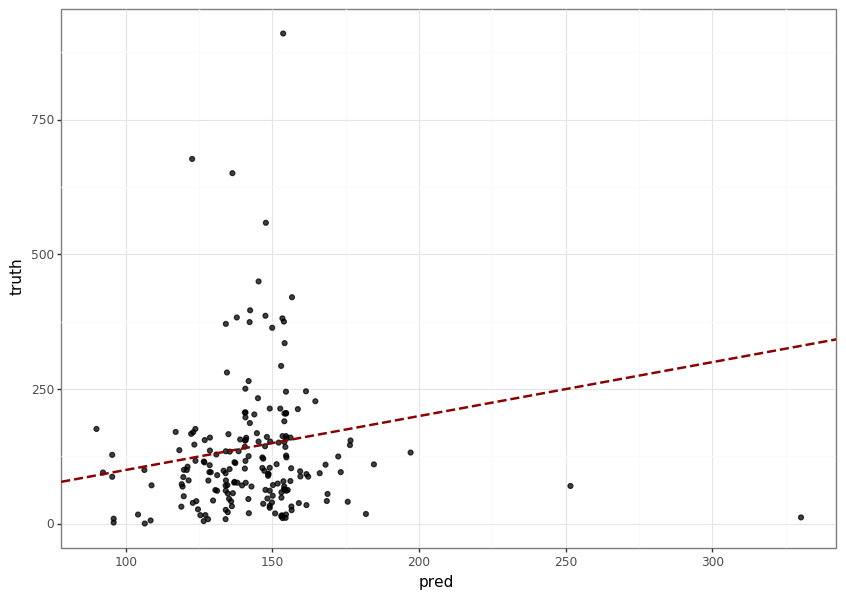

<ggplot: (8765491538285)>

In [117]:
# see how in the pipeline we preprocessed X so it is fixed beforehand and we can make sense of the predictions 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

## Retry while doing preprocessing scaler overtly

In [154]:
y = df_19['saidi_nomed']
X = df_19[['total_cust','nm_pct','ee_pct','dem_res_pct']]

In [155]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [144]:
print(train_X.shape[0]/df_19.shape[0])
print(test_X.shape[0]/df_19.shape[0])

0.7496740547588006
0.2503259452411995


In [152]:
# Plot the continuous variables 
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

AttributeError: 'numpy.ndarray' object has no attribute 'melt'

In [141]:
# Version 3 just log everything
df_19['total_cust'] = np.log(df_19['total_cust'])
df_19['nm_pct'] = np.log(df_19['nm_pct'] + 1)
df_19['ee_pct'] = np.log(df_19['ee_pct'] + 1)
df_19['dem_res_pct'] = np.log(df_19['dem_res_pct'] + 1)

In [157]:
scaler = pp.StandardScaler()

In [158]:
scaler = scaler.fit(train_X)


In [160]:
X_scaled = scaler.transform(train_X)


In [162]:
X_scaled.mean(axis=0)

array([ 2.47145299e-16, -1.39019231e-17, -1.85358975e-17,  9.26794873e-18])

## Unresolved

## Discard